# Notebook with procedures for training and testing of ML-models

In [ ]:
# Library imports
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sb

# Allow imports from the src directory
import sys
import os
from pathlib import Path
sys.path.append(
    str(Path(os.path.dirname(os.path.abspath(os.path.abspath('')))).parents[0]))
import config

In [ ]:
# Import of local files
from train import Train
from model import CNNModel
import model_evaluation

In [ ]:
metadata = np.load(config.PROCESSED_METADATA_FILE_SEGMENTED, allow_pickle=True)

metadata_column_names = ['sample_name', "label", "hive_number", "segment",]
metadata_df = pd.DataFrame(metadata, columns=metadata_column_names)

metadata_df.head()

,sample_name,label,hive_number,segment
0,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment0
1,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment1
2,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment2
3,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment3
4,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment4


## Training auf allen Daten

In [ ]:
trainer = Train(CNNModel(), nn.BCELoss())

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [ ]:
trainer.train_cnn(epochs=20)

Training will happen on cpu.
EPOCH 1


100%|██████████| 125/125 [03:53<00:00,  1.87s/it]


LOSS train: 0.682, val: 0.567
EPOCH 2


100%|██████████| 125/125 [03:40<00:00,  1.77s/it]


LOSS train: 0.606, val: 0.545
EPOCH 3


100%|██████████| 125/125 [03:40<00:00,  1.77s/it]


LOSS train: 0.531, val: 0.397
EPOCH 4


100%|██████████| 125/125 [03:43<00:00,  1.79s/it]


LOSS train: 0.500, val: 0.350
EPOCH 5


100%|██████████| 125/125 [03:40<00:00,  1.77s/it]


LOSS train: 0.458, val: 0.346
EPOCH 6


100%|██████████| 125/125 [03:42<00:00,  1.78s/it]


LOSS train: 0.398, val: 0.263
EPOCH 7


100%|██████████| 125/125 [03:42<00:00,  1.78s/it]


LOSS train: 0.279, val: 0.181
EPOCH 8


100%|██████████| 125/125 [03:42<00:00,  1.78s/it]


LOSS train: 0.158, val: 0.111
EPOCH 9


100%|██████████| 125/125 [03:40<00:00,  1.76s/it]


LOSS train: 0.108, val: 0.047
EPOCH 10


100%|██████████| 125/125 [03:41<00:00,  1.77s/it]


LOSS train: 0.083, val: 0.040
EPOCH 11


100%|██████████| 125/125 [03:41<00:00,  1.77s/it]


LOSS train: 0.068, val: 0.032
EPOCH 12


100%|██████████| 125/125 [03:42<00:00,  1.78s/it]


LOSS train: 0.058, val: 0.028
EPOCH 13


100%|██████████| 125/125 [03:42<00:00,  1.78s/it]


LOSS train: 0.055, val: 0.021
EPOCH 14


100%|██████████| 125/125 [03:42<00:00,  1.78s/it]


LOSS train: 0.048, val: 0.023
EPOCH 15


100%|██████████| 125/125 [03:41<00:00,  1.78s/it]


LOSS train: 0.040, val: 0.022
EPOCH 16


100%|██████████| 125/125 [03:38<00:00,  1.75s/it]


LOSS train: 0.039, val: 0.017
EPOCH 17


100%|██████████| 125/125 [03:37<00:00,  1.74s/it]


LOSS train: 0.034, val: 0.024
EPOCH 18


100%|██████████| 125/125 [03:36<00:00,  1.73s/it]


LOSS train: 0.034, val: 0.014
EPOCH 19


100%|██████████| 125/125 [03:35<00:00,  1.72s/it]


LOSS train: 0.031, val: 0.017
EPOCH 20


100%|██████████| 125/125 [03:36<00:00,  1.73s/it]


LOSS train: 0.028, val: 0.013


In [ ]:
model_name = 'model_20240923_131940_19'

checkpoint_path = '../../models/interim/' + model_name + '_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer.load_model(checkpoint_path, model, optimizer)

In [ ]:
torch.onnx.export(model, next(iter(trainer.training_dataloader))[0], model_name + "_CNN.onnx", input_names=["MEL-Spectrograms"], output_names=["predictions"])

In [ ]:
model_loaded

CNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=17664, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [ ]:
start_epoch

19

In [ ]:
train_samples, val_samples, test_samples

(array(['Hive1 31_05_2018_NO_QueenBee____00_50_00',
        'Hive1 12_06_2018_QueenBee____20_40_00',
        'Hive3_28_07_2017_QueenBee____00_00_00',
        'Hive1 31_05_2018_NO_QueenBee____09_00_00',
        'Hive1 31_05_2018_NO_QueenBee____20_30_00',
        'Hive3_28_07_2017_QueenBee____03_20_00',
        'Hive3_28_07_2017_QueenBee____04_10_00',
        'Hive3_14_07_2017_NO_QueenBee____22_40_00',
        'Hive3_14_07_2017_NO_QueenBee____08_10_00',
        'Hive3_28_07_2017_QueenBee____16_20_00',
        'Hive3_28_07_2017_QueenBee____22_10_00',
        'Hive1 12_06_2018_QueenBee____19_00_00',
        'Hive1 12_06_2018_QueenBee____23_30_00',
        'Hive3_28_07_2017_QueenBee____21_20_00',
        'Hive1 12_06_2018_QueenBee____01_10_00',
        'Hive3_28_07_2017_QueenBee____09_00_00',
        'Hive1 12_06_2018_QueenBee____03_10_00',
        'Hive1 31_05_2018_NO_QueenBee____04_50_00',
        'Hive3_14_07_2017_NO_QueenBee____21_40_00',
        'Hive1 12_06_2018_QueenBee____09_20_00',

In [ ]:
model = model_loaded

In [ ]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 27/27 [00:14<00:00,  1.92it/s]

torch.Size([860])


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted', ylabel='Actual'>

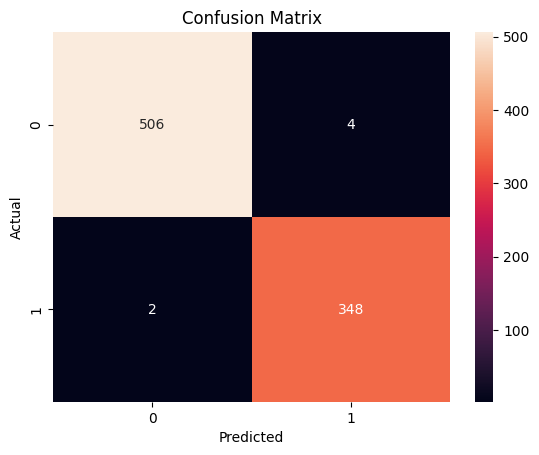

In [ ]:
conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix")
plt

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted', ylabel='Actual'>

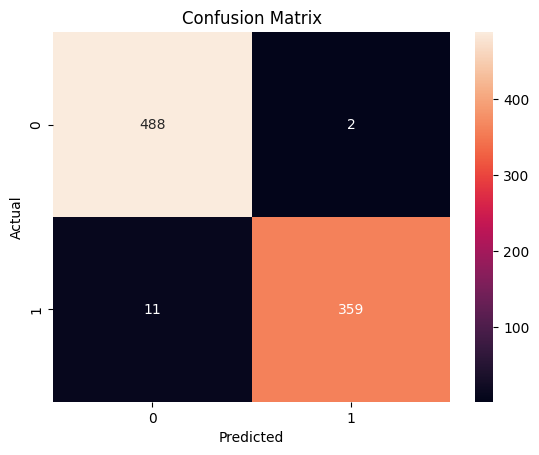

In [ ]:
# Ergebnis aus CNN mit Mel-Spectrogrammen ohne fmax

conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix")
plt

In [ ]:
print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       510
         1.0       0.99      0.99      0.99       350

    accuracy                           0.99       860
   macro avg       0.99      0.99      0.99       860
weighted avg       0.99      0.99      0.99       860



In [ ]:
predictions_test_array = predictions_test[:, np.newaxis]
labels_test_array = labels_test[:, np.newaxis]

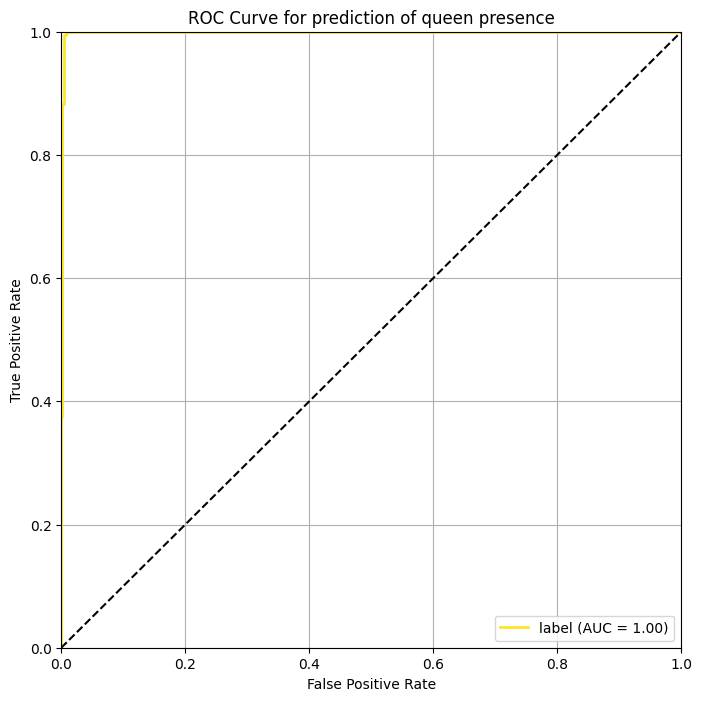

In [ ]:
model_evaluation.plot_roc_curves(labels_test_array, predictions_test_array, classes=["label"], title="ROC Curve for prediction of queen presence")

## Hive-Indepentent (Training-Hive 1, Test-Hive 3)

In [ ]:
trainer_hive_independent = Train(CNNModel(), nn.BCELoss(), training_hive=1)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [ ]:
trainer_hive_independent.train_cnn(epochs=20)

Training will happen on cpu.
EPOCH 1


100%|██████████| 62/62 [02:19<00:00,  2.25s/it]


LOSS train: 0.693, val: 0.632
EPOCH 2


100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


LOSS train: 0.680, val: 0.617
EPOCH 3


100%|██████████| 62/62 [02:16<00:00,  2.21s/it]


LOSS train: 0.654, val: 0.584
EPOCH 4


100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


LOSS train: 0.586, val: 0.525
EPOCH 5


100%|██████████| 62/62 [02:10<00:00,  2.11s/it]


LOSS train: 0.519, val: 0.459
EPOCH 6


100%|██████████| 62/62 [01:58<00:00,  1.92s/it]


LOSS train: 0.443, val: 0.373
EPOCH 7


100%|██████████| 62/62 [01:58<00:00,  1.91s/it]


LOSS train: 0.343, val: 0.246
EPOCH 8


100%|██████████| 62/62 [01:55<00:00,  1.86s/it]


LOSS train: 0.224, val: 0.169
EPOCH 9


100%|██████████| 62/62 [01:58<00:00,  1.90s/it]


LOSS train: 0.145, val: 0.111
EPOCH 10


100%|██████████| 62/62 [01:51<00:00,  1.80s/it]


LOSS train: 0.098, val: 0.078
EPOCH 11


100%|██████████| 62/62 [01:53<00:00,  1.83s/it]


LOSS train: 0.078, val: 0.063
EPOCH 12


100%|██████████| 62/62 [01:52<00:00,  1.81s/it]


LOSS train: 0.066, val: 0.098
EPOCH 13


100%|██████████| 62/62 [01:46<00:00,  1.72s/it]


LOSS train: 0.054, val: 0.053
EPOCH 14


100%|██████████| 62/62 [01:27<00:00,  1.40s/it]


LOSS train: 0.060, val: 0.049
EPOCH 15


100%|██████████| 62/62 [01:45<00:00,  1.71s/it]


LOSS train: 0.050, val: 0.059
EPOCH 16


100%|██████████| 62/62 [01:48<00:00,  1.75s/it]


LOSS train: 0.047, val: 0.042
EPOCH 17


100%|██████████| 62/62 [01:40<00:00,  1.62s/it]


LOSS train: 0.040, val: 0.043
EPOCH 18


100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


LOSS train: 0.036, val: 0.039
EPOCH 19


100%|██████████| 62/62 [01:39<00:00,  1.61s/it]


LOSS train: 0.035, val: 0.037
EPOCH 20


100%|██████████| 62/62 [01:41<00:00,  1.63s/it]


LOSS train: 0.035, val: 0.047


In [ ]:
model_name = 'model_20240923_155143_18'

checkpoint_path = '../../models/interim/' + model_name + '_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer_hive_independent.load_model(checkpoint_path, model, optimizer)

In [ ]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer_hive_independent.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 90/90 [02:25<00:00,  1.61s/it]

torch.Size([2857])


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted', ylabel='Actual'>

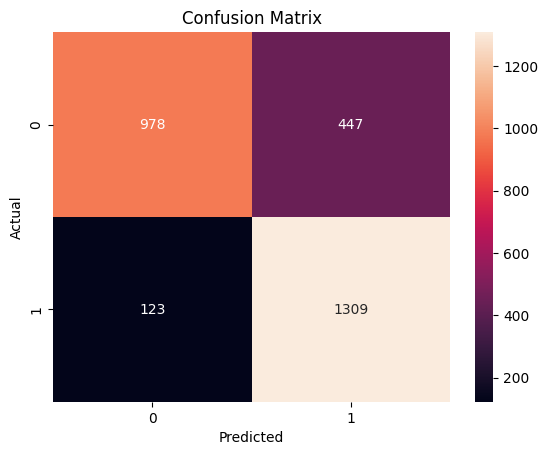

In [ ]:
conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix")
plt

In [ ]:
print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       0.89      0.69      0.77      1425
         1.0       0.75      0.91      0.82      1432

    accuracy                           0.80      2857
   macro avg       0.82      0.80      0.80      2857
weighted avg       0.82      0.80      0.80      2857



In [ ]:
predictions_test_array = predictions_test[:, np.newaxis]
labels_test_array = labels_test[:, np.newaxis]

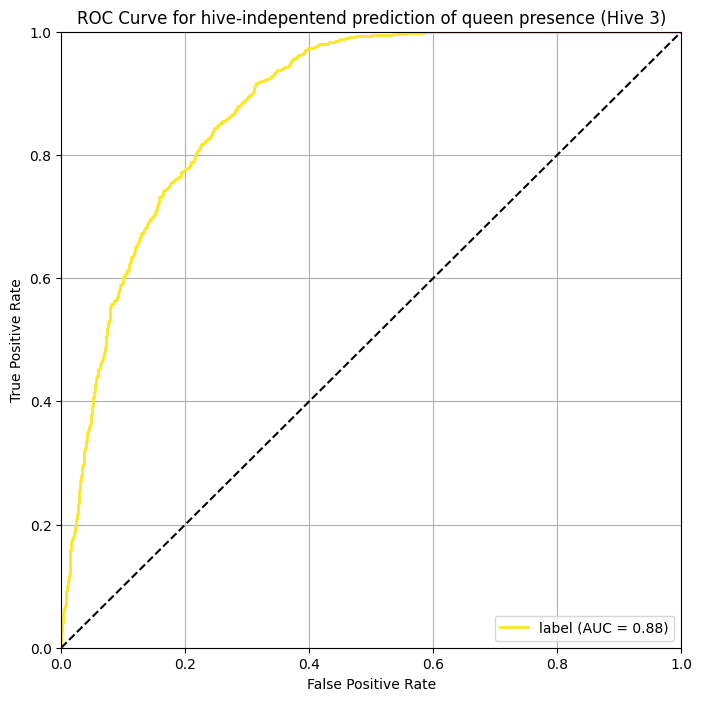

In [ ]:
model_evaluation.plot_roc_curves(labels_test_array, predictions_test_array, classes=["label"], title="ROC Curve for hive-indepentend prediction of queen presence (Hive 3)")

## Hive-Indepentent (Training-Hive 3, Test-Hive 1)

In [ ]:
trainer_hive_independent = Train(CNNModel(), nn.BCELoss(), training_hive=3)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [ ]:
trainer_hive_independent.train_cnn(epochs=20)

Training will happen on cpu.
EPOCH 1


100%|██████████| 63/63 [01:51<00:00,  1.78s/it]


LOSS train: 0.677, val: 0.604
EPOCH 2


100%|██████████| 63/63 [01:56<00:00,  1.84s/it]


LOSS train: 0.551, val: 0.430
EPOCH 3


100%|██████████| 63/63 [02:23<00:00,  2.28s/it]


LOSS train: 0.348, val: 0.437
EPOCH 4


100%|██████████| 63/63 [02:14<00:00,  2.14s/it]


LOSS train: 0.309, val: 0.326
EPOCH 5


100%|██████████| 63/63 [01:50<00:00,  1.75s/it]


LOSS train: 0.263, val: 0.287
EPOCH 6


100%|██████████| 63/63 [02:04<00:00,  1.97s/it]


LOSS train: 0.251, val: 0.305
EPOCH 7


100%|██████████| 63/63 [01:56<00:00,  1.85s/it]


LOSS train: 0.242, val: 0.315
EPOCH 8


100%|██████████| 63/63 [02:04<00:00,  1.97s/it]


LOSS train: 0.218, val: 0.332
EPOCH 9


100%|██████████| 63/63 [02:32<00:00,  2.42s/it]


LOSS train: 0.197, val: 0.283
EPOCH 10


100%|██████████| 63/63 [02:43<00:00,  2.59s/it]


LOSS train: 0.163, val: 0.235
EPOCH 11


100%|██████████| 63/63 [01:37<00:00,  1.55s/it]


LOSS train: 0.139, val: 0.188
EPOCH 12


100%|██████████| 63/63 [01:35<00:00,  1.52s/it]


LOSS train: 0.125, val: 0.153
EPOCH 13


100%|██████████| 63/63 [01:41<00:00,  1.61s/it]


LOSS train: 0.098, val: 0.131
EPOCH 14


100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


LOSS train: 0.083, val: 0.140
EPOCH 15


100%|██████████| 63/63 [02:20<00:00,  2.23s/it]


LOSS train: 0.073, val: 0.105
EPOCH 16


100%|██████████| 63/63 [02:04<00:00,  1.98s/it]


LOSS train: 0.056, val: 0.082
EPOCH 17


100%|██████████| 63/63 [02:02<00:00,  1.94s/it]


LOSS train: 0.049, val: 0.055
EPOCH 18


100%|██████████| 63/63 [01:59<00:00,  1.90s/it]


LOSS train: 0.046, val: 0.085
EPOCH 19


100%|██████████| 63/63 [01:56<00:00,  1.86s/it]


LOSS train: 0.041, val: 0.045
EPOCH 20


100%|██████████| 63/63 [01:58<00:00,  1.89s/it]


LOSS train: 0.036, val: 0.039


In [ ]:
model_name = 'model_20240923_171634_19'

checkpoint_path = '../../models/interim/' + model_name + '_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer_hive_independent.load_model(checkpoint_path, model, optimizer)

In [ ]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer_hive_independent.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 89/89 [03:01<00:00,  2.04s/it]

torch.Size([2832])


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted', ylabel='Actual'>

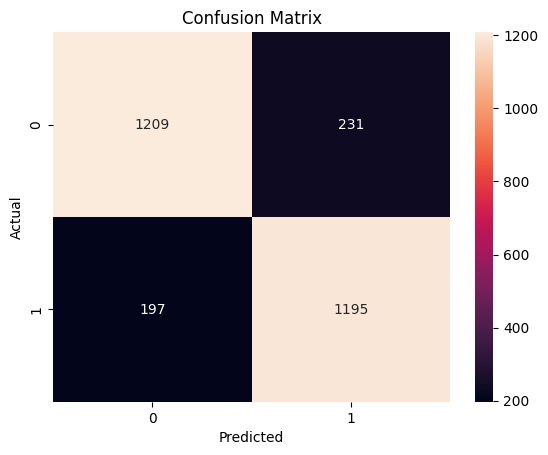

In [ ]:
conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix")
plt

In [ ]:
print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      1440
         1.0       0.84      0.86      0.85      1392

    accuracy                           0.85      2832
   macro avg       0.85      0.85      0.85      2832
weighted avg       0.85      0.85      0.85      2832



In [ ]:
predictions_test_array = predictions_test[:, np.newaxis]
labels_test_array = labels_test[:, np.newaxis]

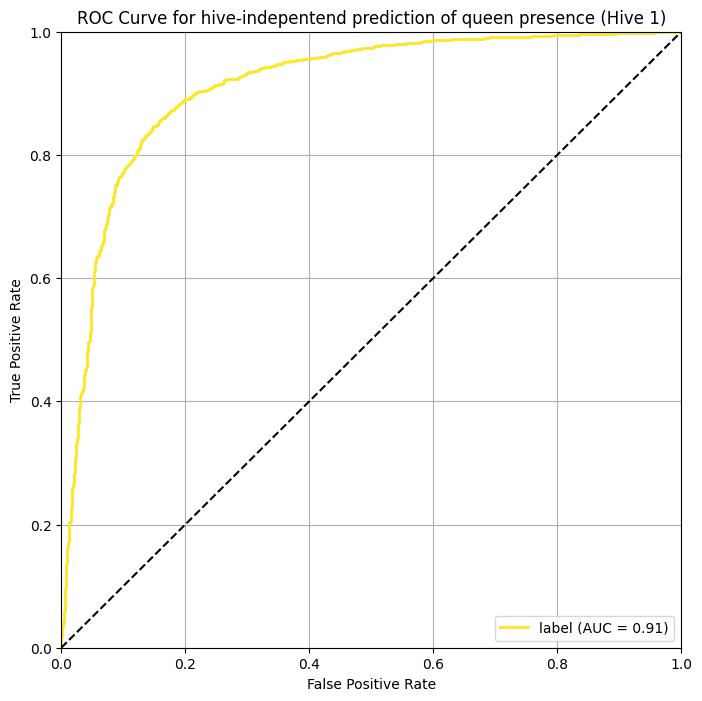

In [ ]:
model_evaluation.plot_roc_curves(labels_test_array, predictions_test_array, classes=["label"], title="ROC Curve for hive-indepentend prediction of queen presence (Hive 1)")